In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
import os, sys
import ruamel.yaml as yaml
import itertools
from scipy.stats import mannwhitneyu,ks_2samp

plot_dir = "/Users/eric/repos/gohr/misc/ml_plots/neurips/"

if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [22]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Location of rule runs
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/neurips_2023/mosaic/"
#rule_runs_path = "/Users/eric/repos/gohr/active/outputs/neurips_2023/common_final/"
cluster_runs = [name for name in os.listdir(rule_runs_path) if name!=".DS_Store"]
runs_to_analyze = ["naive_bd_ad_n2","naive_bd_ad_n4","naive_bd_ad_n6","naive_bd_ad_n8",
                   "naive_bs_ad_n2","naive_bs_ad_n4","naive_bs_ad_n6","naive_bs_ad_n8",
                   "naive_bd_as_n2","naive_bd_as_n4","naive_bd_as_n6","naive_bd_as_n8",
                   "naive_bda_as_n2","naive_bda_as_n4","naive_bda_as_n6","naive_bda_as_n8",
                   "naive_bs_as_n2","naive_bs_as_n4","naive_bs_as_n6","naive_bs_as_n8",
                   "naive_bsd_asd_n2","naive_bsd_asd_n4","naive_bsd_asd_n6","naive_bsd_asd_n8"]
#runs_to_analyze=["naive_bd_ad_n6","naive_bd_ad_n8"]

# Create lists that will hold dataframes for concatenation
episode_df_list = []
terminal_results_list = []
placeholder_value = np.nan
# DQN
#delta_horizon=150
# REINFORCE
delta_horizon=150
# Loop over the specified rule runs
for cluster_run in cluster_runs:
    cluster_run_path = rule_runs_path+cluster_run+"/"
    for run in runs_to_analyze:
        available_runs = [name for name in os.listdir(cluster_run_path) if name!=".DS_Store"]
        if run not in available_runs:
            continue
        # Form complete run path
        run_path = cluster_run_path+run
            
        # Get the experiments for that run (each one is a set of trials for a particular rule)
        experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]

        # Loop over the experiments
        for experiment in experiments:
            # Get the cluster id
            cluster_trial = experiment.split("_")[0]
            cluster_process = experiment.split("_")[1]
            cluster_id = cluster_trial+"_"+cluster_process
            # String length may vary
            id_str_length = len(cluster_id)
            # Get the corresponding rule name
            rule_name = experiment[id_str_length+1:]
            # For complete experiment path
            experiment_path = os.path.join(run_path,experiment)
            
            trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]

            for trial in trials:
                trial_path = os.path.join(experiment_path,trial)
                # Get parameters
                yaml_path = os.path.join(trial_path,"data.yaml")
                with open(yaml_path, 'r') as param_file:
                    args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                    featurization =args["FEATURIZATION"]
                    learner = args["LEARNER"]
                # Import episodic data and process relevant columns
                episodic_data_path = os.path.join(trial_path,"episode_data.csv")
                trial_results = pd.read_csv(episodic_data_path)
                #move_results = pd.read_csv(move_data_path,index_col=0,usecols=['episode','time','reward'])
                
                # Episode processing
                trial_results["rule"]=rule_name
                trial_results["params"]=run
                trial_results["memory"]=int(run[-1])
                trial_results["experiment_id"]=cluster_id
                trial_results["trial"]=trial
                trial_results["featurization"]=featurization
                trial_results["learner"]=learner
                trial_results["ep_error"]=-1*trial_results["reward"]
                trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
                #if trial_results.episode.max()!=1999:
                    #print(trial_results.cluster_id.unique())
                #    continue
                delta_horizon_err_val = trial_results.cumulative_error.iloc[-delta_horizon]
                delta = trial_results.cumulative_error.iloc[-1]-trial_results.cumulative_error.iloc[-delta_horizon]
                #trial_results["100_ep_delta"]=delta

                # DQN
                #converged = (delta/(delta_horizon*9+delta))<0.001
                converged = (delta/(delta_horizon*9+delta))<0.0025
                #trial_results["converged"]=converged
                term_entry = trial_results.iloc[-1].to_frame().transpose()
                tce = term_entry.cumulative_error
                term_entry["converged"]=converged
                if converged:
                    adj_error=tce
                else:
                    adj_error=placeholder_value
                term_entry["adj_cumulative_error"]=adj_error
                term_entry["delta"]=delta
                term_entry['horizon_err']=delta_horizon_err_val
                terminal_results_list.append(term_entry)
                test_ser = trial_results.iloc[-1]
                episode_df_list.append(trial_results)
            
# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)
terminal_results_df = pd.concat(terminal_results_list,ignore_index=True)

In [81]:
display(terminal_results_df)

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
0,19999,0,QN,naive_bd_ad_n6,6,11068027_373,0,BD_AD,REINFORCE,0,266,True,266.0,0,266
1,19999,0,CM1F,naive_bd_ad_n6,6,11068027_211,0,BD_AD,REINFORCE,0,14565,False,NaN,5,14560
2,19999,0,BT,naive_bd_ad_n6,6,11068027_494,0,BD_AD,REINFORCE,0,1204,True,1204.0,0,1204
3,19999,0,SM1F,naive_bd_ad_n6,6,11068027_92,0,BD_AD,REINFORCE,0,13817,True,13817.0,1,13816
4,19999,0,CW2F,naive_bd_ad_n6,6,11068027_293,0,BD_AD,REINFORCE,0,2504,True,2504.0,0,2504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5193,1999,0,CW,naive_bsd_asd_n2,2,11068052_277,0,BSD_ASD,DQN,0,752,True,752.0,0,752
5194,1999,0,SM,naive_bsd_asd_n2,2,11068052_38,0,BSD_ASD,DQN,0,1560,False,NaN,6,1554
5195,1999,0,QN2F,naive_bsd_asd_n2,2,11068052_434,0,BSD_ASD,DQN,0,185,True,185.0,0,185
5196,1999,0,BLTR,naive_bsd_asd_n2,2,11068052_473,0,BSD_ASD,DQN,0,380,True,380.0,0,380


In [23]:
# Rule name replacement
episode_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)
terminal_results_df.replace(to_replace={ '1_1_shape_4m':'SM','1_2_shape_4m':'SM2O','1_1_shape_3m_cua':'SM1F',
                                '1_1_color_4m':'CM','1_2_color_4m':'CM2O','1_1_color_3m_cua':'CM1F',
                                'clockwiseZeroStart':'CW','clockwiseTwoFreeAlt':'CWAF','clockwiseTwoFree':'CW2F',
                                'quadrantNearby':'QN','quadrantNearbyTwoFree':'QN2F',
                                'bottomLeft_then_topRight':'BLTR','bottom_then_top':'BT'},inplace=True)

# Featurization replacement
episode_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)
terminal_results_df.replace(to_replace={ 'NAIVE_N_BD_AD':'BD_AD',
                                        'NAIVE_N_BD_AS':'BD_AS',
                                        'NAIVE_N_BS_AD':'BS_AD',
                                        'NAIVE_N_BS_AS':'BS_AS',
                                        'NAIVE_N_BDa_AS':'BDa_AS',
                                        'NAIVE_N_BSD_ASD':'BSD_ASD'
                                        },inplace=True)

# complete_rules = ["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m",
#                 "1_1_color_4m","1_1_color_3m_cua","1_2_color_4m", 
#                 "clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree",
#                 "quadrantNearby","quadrantNearbyTwoFree",
#                 "bottomLeft_then_topRight","bottom_then_top"]
complete_rules = ["SM","SM1F","SM2O","CM","CM1F","CM2O","QN","QN2F","BLTR","BT","CW","CWAF","CW2F"]
base_rules = ["SM","CM","QN","BLTR","CW"]
steps = [2,4,6,8]

In [10]:
results_df = terminal_results_df.query("learner=='DQN' & memory==2 & featurization=='BD_AD' & rule=='SM'")
results_df.count()

episode                 20
reward                  20
rule                    20
params                  20
memory                  20
experiment_id           20
trial                   20
featurization           20
learner                 20
ep_error                20
cumulative_error        20
converged               20
adj_cumulative_error    19
delta                   20
horizon_err             20
dtype: int64

In [24]:
# DQN array plotting
complete_list = episode_results_df.rule.unique()
# rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
#                 #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
#                 #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
#                 {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,2500]},
#                 {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,2500]}, 
#                 {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
#                 {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
#                 {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top"],"y":[0,1500]}
#                 ]
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","tname":"Shape rules","rules":["SM","SM1F","SM2O"],"y":[0,3000],"tick_step":500},
                {"name":"color_rules","tname":"Color rules","rules":["CM","CM1F","CM2O"],"y":[0,3000],"tick_step":500}, 
                {"name":"clockwise_rules","tname":"Clockwise rules","rules":["CW","CWAF","CW2F"],"y":[0,3000],"tick_step":500},
                {"name":"quadrant_rules","tname":"Quadrant rules","rules":["QN","QN2F"],"y":[0,400],"tick_step":100},
                {"name":"bottom_top_rules","tname":"Alternating rules","rules":["BLTR","BT"],"y":[0,800],"tick_step":200}
                ]

steps = [2,4,6,8]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps),hspace=.3)
#feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
feats = ["BD_AD","BS_AD","BD_AS","BS_AS", "BSD_ASD"]

In [28]:
# REINFORCE array plotting
complete_list = episode_results_df.rule.unique()
rules_list = [#{"name":"all_rules","rules":complete_list,"y":[0,4000]},
                #{"name":"quick_test","rules":["1_1_shape_4m","1_2_shape_4m"],"y":[0,2500]}
                #{"name":"base_rules","rules":["1_1_shape_4m","clockwiseZeroStart","quadrantNearby","bottomLeft_then_topRight"],"y":[0,4000]},
                {"name":"shape_rules","tname":"Shape rules","rules":["SM","SM1F","SM2O"],"y":[0,25000], "tick_step":5000},
                {"name":"color_rules","tname":"Color rules","rules":["CM","CM1F","CM2O"],"y":[0,25000], "tick_step":5000}, 
                {"name":"clockwise_rules","tname":"Clockwise rules","rules":["CW","CWAF","CW2F"],"y":[0,25000], "tick_step":5000},
                {"name":"quadrant_rules","tname":"Quadrant rules","rules":["QN","QN2F"],"y":[0,400], "tick_step":100},
                {"name":"bottom_top_rules","tname":"Alternating rules","rules":["BLTR","BT"],"y":[0,8000], "tick_step":2000}
                ]

steps = [2,4,6,8]
print(steps)
gs = GridSpec(nrows = len(rules_list),ncols=len(steps),hspace=0.25)
#feats = ["NAIVE_N_BD_AD","NAIVE_N_BS_AD","NAIVE_N_BD_AS","NAIVE_N_BDa_AS","NAIVE_N_BS_AS", "NAIVE_N_BSD_ASD"]
feats = ["BD_AD","BS_AD","BD_AS","BS_AS", "BSD_ASD"]

[2, 4, 6, 8]


In [25]:
learners = ["DQN","REINFORCE"]
for learner in learners:
    #print(learner)
    for idx,step in enumerate(steps):
        #print(step)
        for i in range(len(rules_list)):
            sub_dict = rules_list[i]
            sub_list = sub_dict["rules"]
            name = sub_dict["name"]
            tname = sub_dict["tname"]
            for feat in feats:
                for rule in sub_list:
                    results_df = terminal_results_df.query("learner==@learner & memory==@step & featurization==@feat & rule==@rule")
                    count = results_df.cumulative_error.count()
                    if count!=20:
                        print(learner,step,feat,rule,count)

In [73]:

reduced_results.head()

/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_2342/3572120052.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_results["Rule"] = reduced_results.rule
/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_2342/3572120052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_results["Featurization"]=reduced_results.featurization


,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,Rule,Featurization
23380000,0,-15,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,15,15,CW2F,BD_AD
23380001,1,-10,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,10,25,CW2F,BD_AD
23380002,2,-13,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,13,38,CW2F,BD_AD
23380003,3,-28,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,28,66,CW2F,BD_AD
23380004,4,-11,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,11,77,CW2F,BD_AD


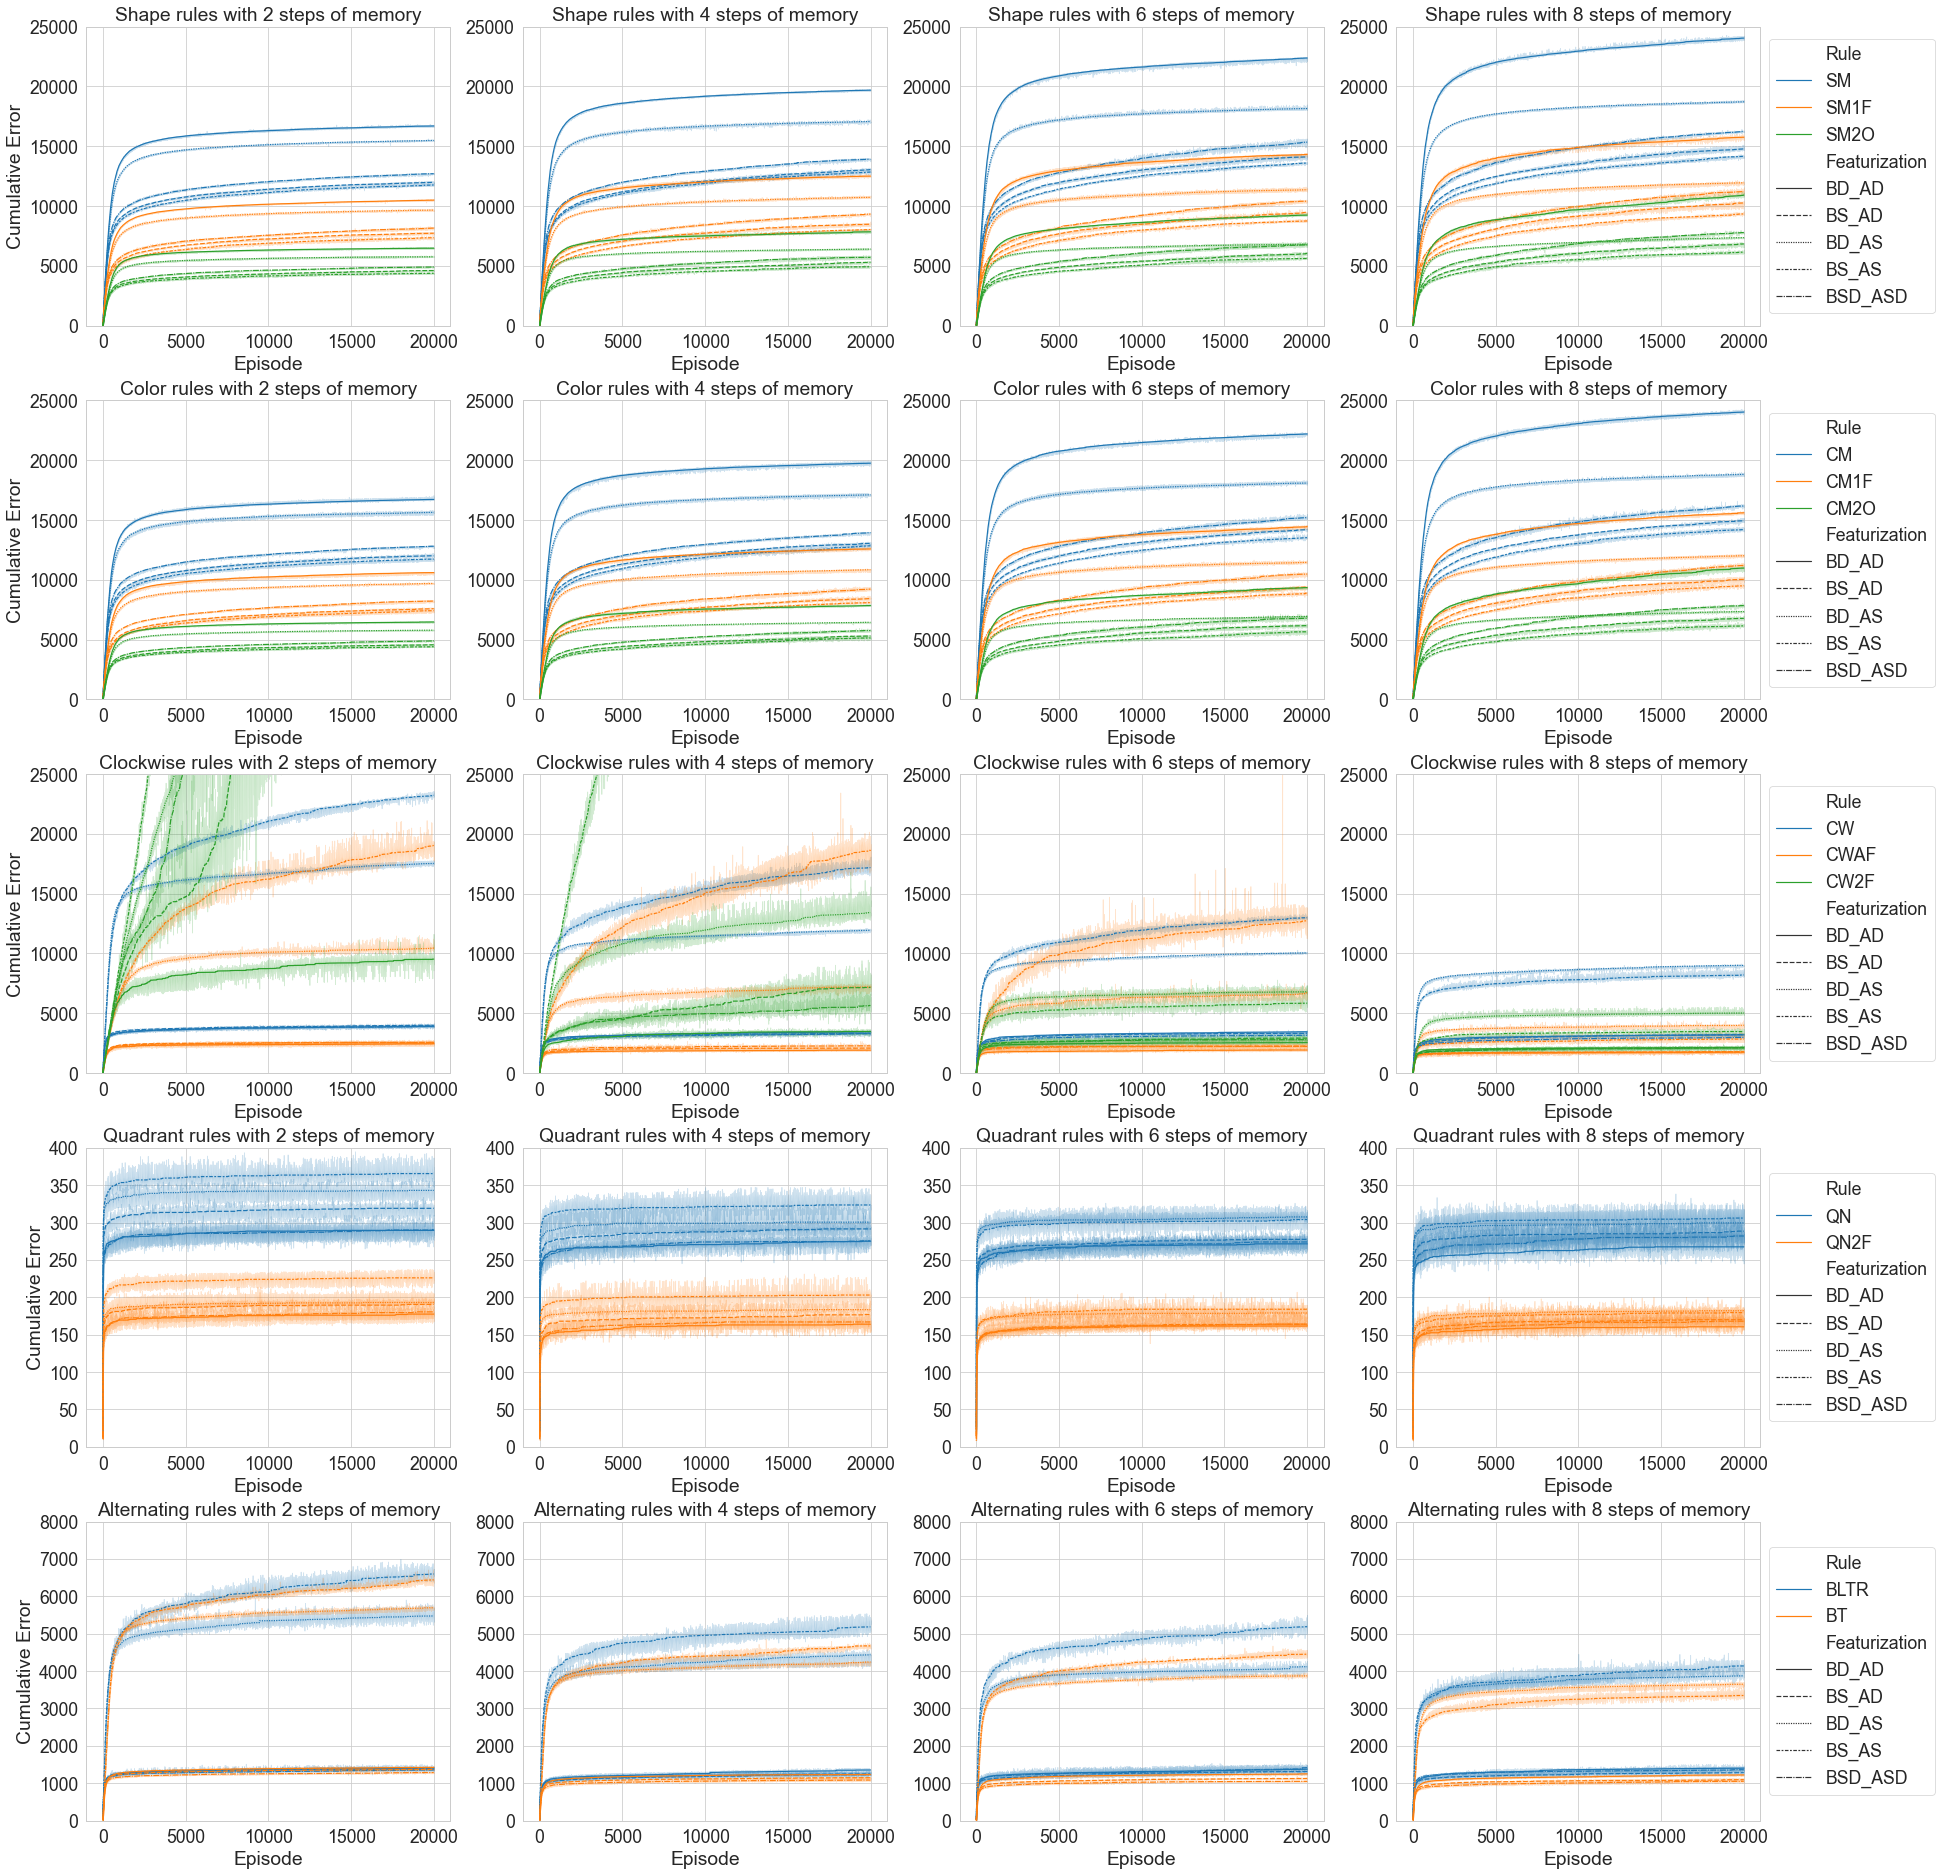

In [31]:
learner='REINFORCE'
# Array plotting
reduced_results = episode_results_df.query("episode%5==0 & learner==@learner").copy()
reduced_results["Rule"] = reduced_results.rule
reduced_results["Featurization"]=reduced_results.featurization
# Create a figure grid for all results
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
fig = plt.figure(figsize=(30,33))
for idx,step in enumerate(steps):
    #results_df = episode_results_df[episode_results_df.memory==step]
    results_df = reduced_results[reduced_results.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        tname = sub_dict["tname"]
        ax = fig.add_subplot(gs[i,idx])
        df = results_df.query("rule in @sub_list").copy()
        if not(step==8):
            ax=sns.lineplot(data=df,y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=500, estimator=np.median,hue="Rule",hue_order=sub_list,style="Featurization",style_order=feats,legend=False)
        else:
            ax=sns.lineplot(data=df,y="cumulative_error",x="episode",errorbar=("ci",95),n_boot=500, estimator=np.median,hue="Rule",hue_order=sub_list,style="Featurization",style_order=feats)
            #errorbar=("ci",95),n_boot=1
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(tname+" with {} steps of memory".format(str(step)))
        ax.set_ylim(np.array(sub_dict["y"]))
        if step==2:
            ax.set_ylabel("Cumulative Error")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Episode")
#plt.savefig(plot_dir+'dqn_500_500_ml_6_ways.pdf',bbox_inches='tight',facecolor='w')
plt.savefig(plot_dir+'med_learning_feats_'+learner+'.pdf',bbox_inches='tight',facecolor='w')

In [125]:
steps=[2,4,6,8]

In [63]:
terminal_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
0,19999,0,CWAF,naive_bd_ad_n2,2,11067788_41,0,BD_AD,REINFORCE,0,2395,True,2395.0,1,2394
1,19999,0,CW2F,naive_bd_ad_n2,2,11067788_36,0,BD_AD,REINFORCE,0,9880,True,9880.0,0,9880
2,19999,0,CM1F,naive_bd_ad_n2,2,11067788_26,0,BD_AD,REINFORCE,0,10614,False,NaN,4,10610
3,19999,0,CM2O,naive_bd_ad_n2,2,11067788_21,0,BD_AD,REINFORCE,0,6437,True,6437.0,3,6434
4,19999,0,QN2F,naive_bd_ad_n2,2,11067788_51,0,BD_AD,REINFORCE,0,176,True,176.0,0,176


In [66]:
display(terminal_results_df.query("learner=='DQN'  & featurization=='BD_AD' & memory==6"))

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
130,1999,0,CW2F,naive_bd_ad_n6,6,11067794_36,0,BD_AD,DQN,0,375,True,375.0,1,374
131,1999,0,CM,naive_bd_ad_n6,6,11067794_16,0,BD_AD,DQN,0,2572,True,2572.0,2,2570
132,1999,0,SM2O,naive_bd_ad_n6,6,11067794_6,0,BD_AD,DQN,0,1065,True,1065.0,3,1062
133,1999,0,CM1F,naive_bd_ad_n6,6,11067794_26,0,BD_AD,DQN,0,1628,False,NaN,7,1621
134,1999,0,BT,naive_bd_ad_n6,6,11067794_61,0,BD_AD,DQN,0,295,True,295.0,0,295
135,1999,0,CW,naive_bd_ad_n6,6,11067794_31,0,BD_AD,DQN,0,586,False,NaN,4,582
136,1999,0,CM2O,naive_bd_ad_n6,6,11067794_21,0,BD_AD,DQN,0,1149,True,1149.0,3,1146
137,1999,0,QN2F,naive_bd_ad_n6,6,11067794_51,0,BD_AD,DQN,0,169,True,169.0,0,169
138,1999,0,CWAF,naive_bd_ad_n6,6,11067794_41,0,BD_AD,DQN,0,358,True,358.0,1,357
139,1999,0,BLTR,naive_bd_ad_n6,6,11067794_56,0,BD_AD,DQN,0,363,True,363.0,0,363


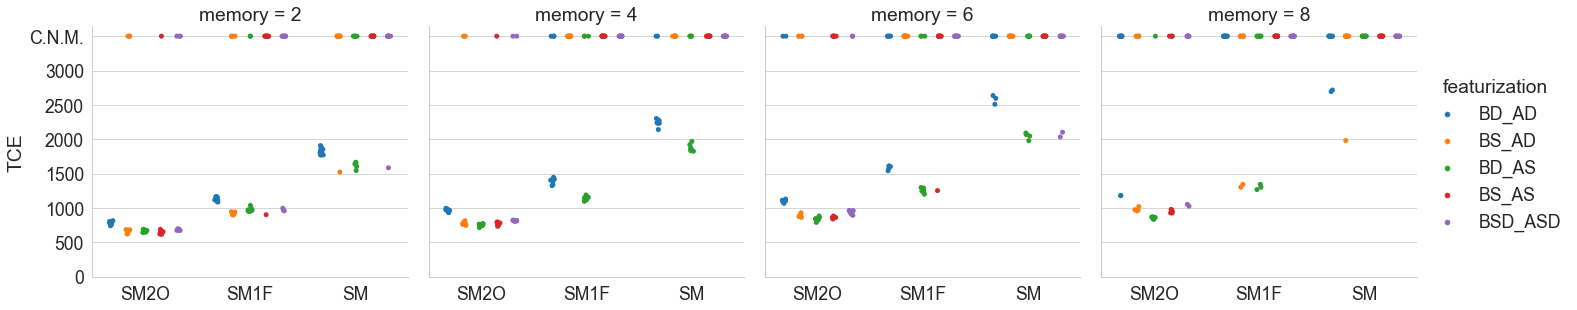

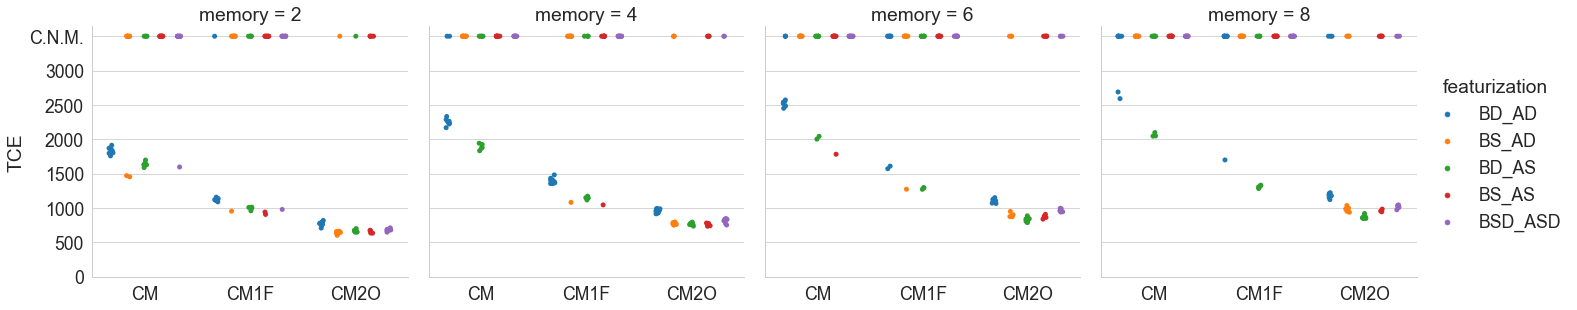

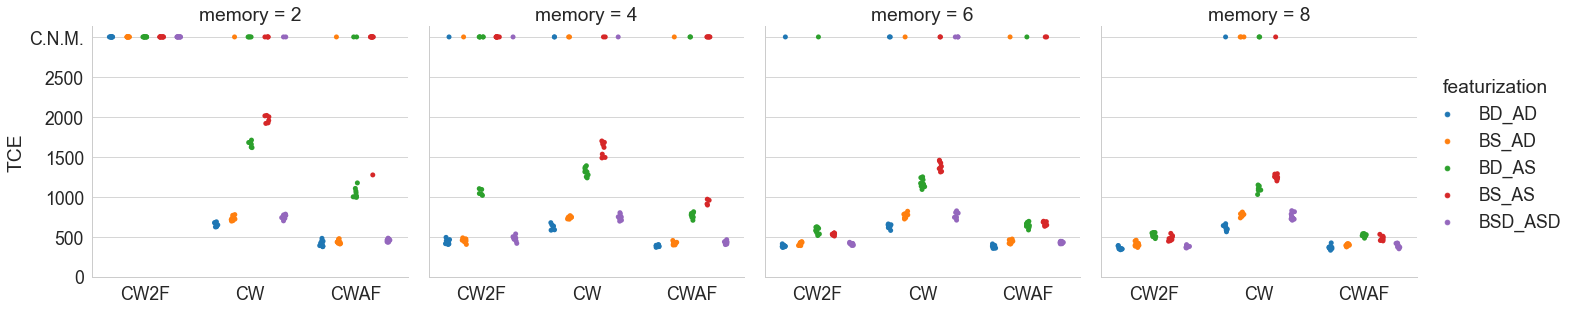

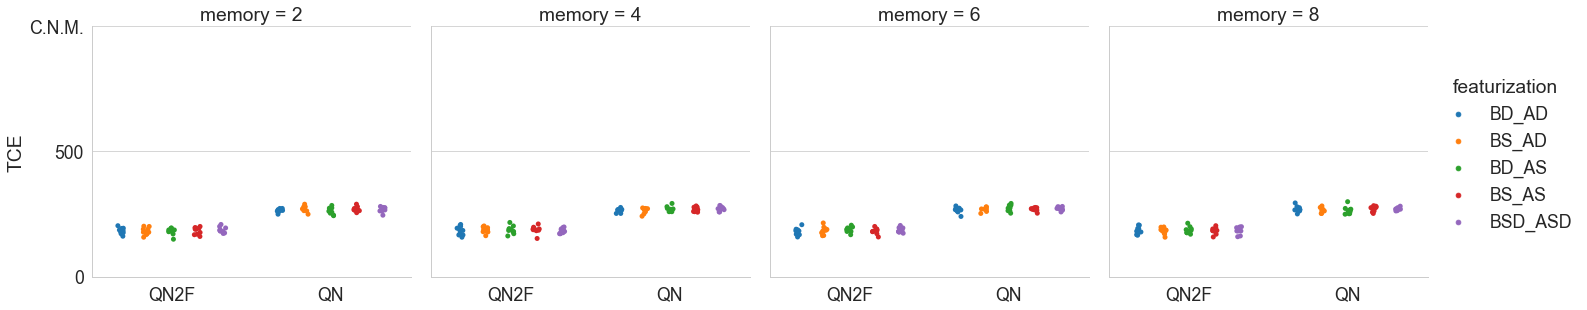

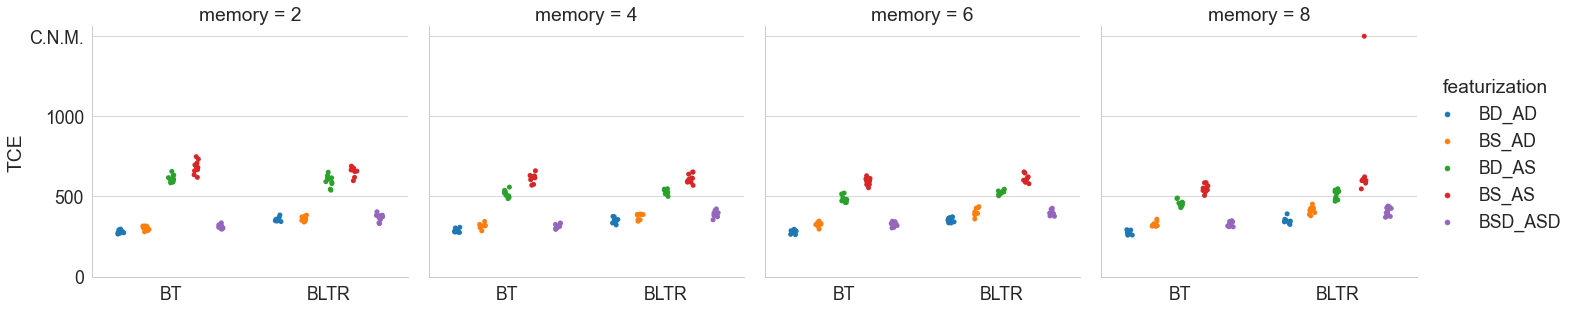

In [120]:
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
#fig,axs = plt.subplots(constrained_layout=True,figsize=(30,33))
#subfigs=fig.subfigures(len(rules_list),1,hspace=0.5)
#fig, axs = plt.subplots(len(rules_list), 1, layout='constrained', figsize=(30, 33))
#gridspec = axs[0, 0].get_subplotspec().get_gridspec()
results_df = terminal_results_df.query("learner=='DQN'").copy()

for i in range(len(rules_list)):

    sub_dict = rules_list[i]
    sub_list = sub_dict["rules"]
    name = sub_dict["name"]
    tname = sub_dict["tname"]
    step = 500
    tick_max= int((np.ceil(results_df.query("rule in @sub_list").adj_cumulative_error.max()/step)+2)*step)
    ticks = [*range(0,tick_max,step)]
    str_ticks = [str(i) for i in ticks]
    str_ticks[-1]='C.N.M.'
    g=sns.catplot(data=results_df.query("rule in @sub_list").fillna(ticks[-1]), x='rule',y='adj_cumulative_error',col='memory',hue='featurization',dodge=True,kind='strip')
    g.set_axis_labels("","TCE")
    #g.set_yticks(ticks)
    #g.set_yticklabels(str_ticks)
    lax = g.axes.flat[0]
    lax.set_yticks(ticks)
    lax.set_yticklabels(str_ticks)


/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_2342/3410188476.py:37: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(plot_dir+"terminal_strip_feats_"+learner+".pdf",bbox_inches='tight',facecolor='w')
/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_2342/3410188476.py:37: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(plot_dir+"terminal_strip_feats_"+learner+".pdf",bbox_inches='tight',facecolor='w')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


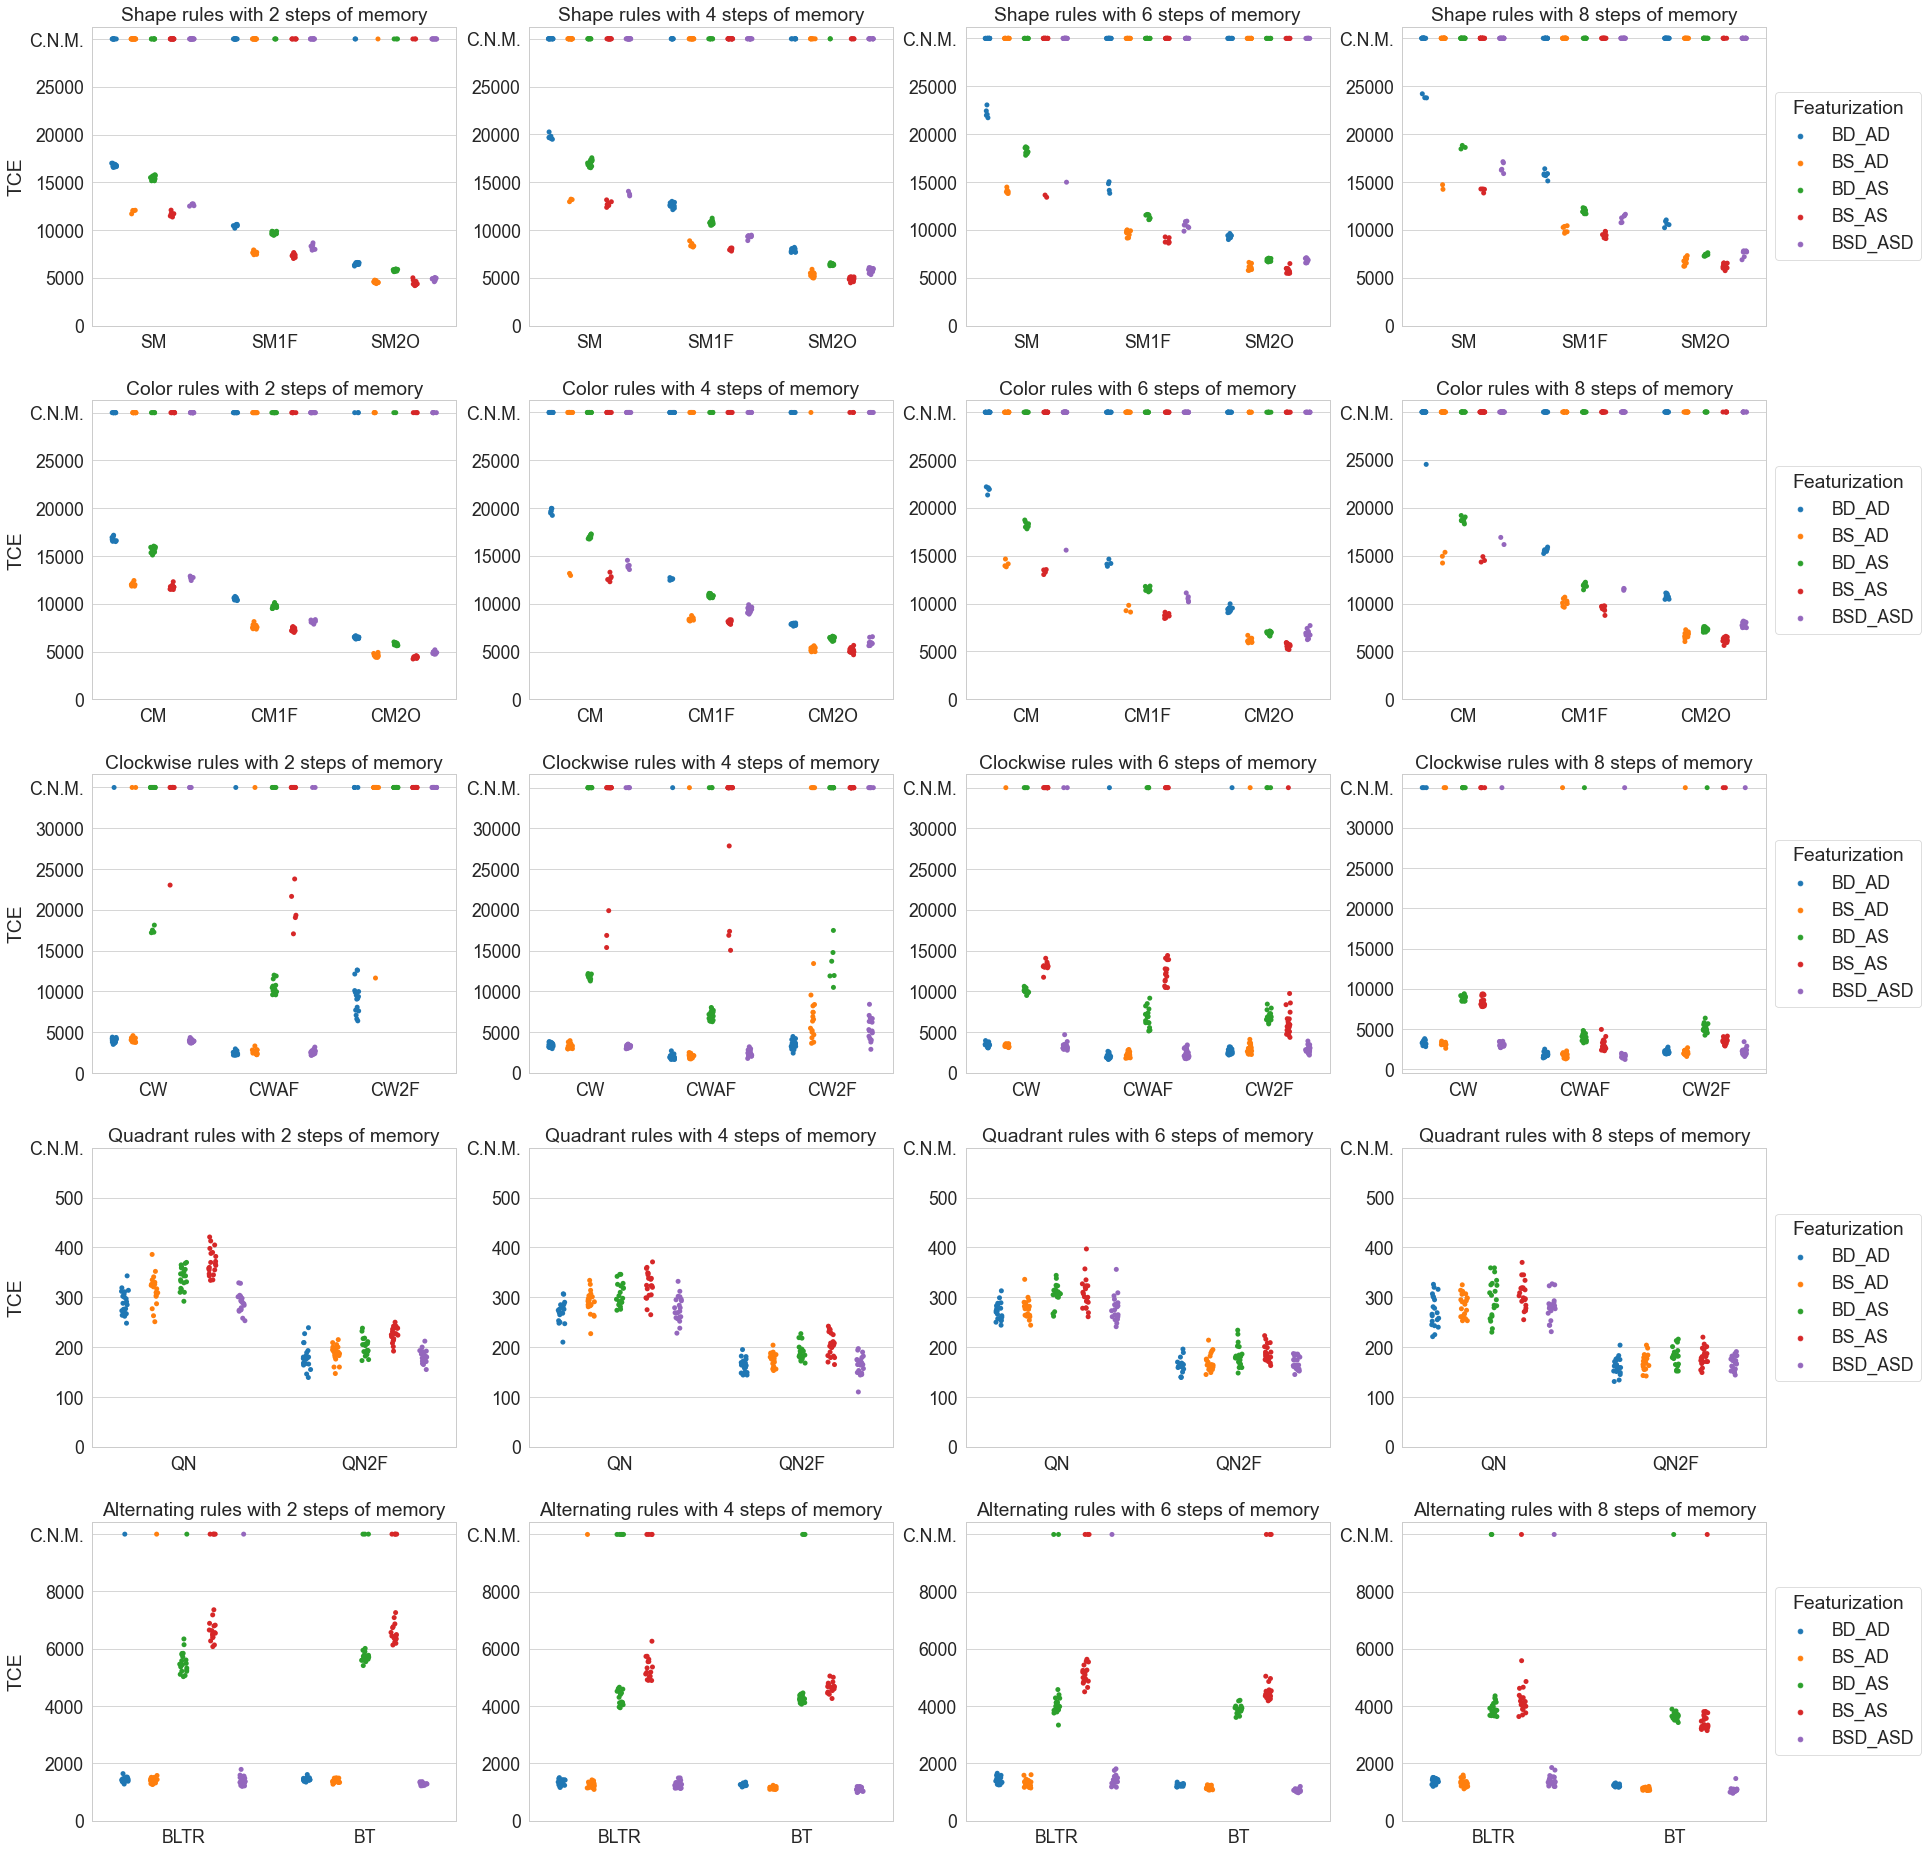

In [166]:
# Create a figure grid for all results
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
fig = plt.figure(figsize=(30,33),constrained_layout=True)

learner = 'REINFORCE'
for idx,step in enumerate(steps):
    #results_df = episode_results_df[episode_results_df.memory==step]
    results_df = terminal_results_df.query("memory==@step & learner==@learner").copy()
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        tname = sub_dict["tname"]
        tick_step = sub_dict["tick_step"]
        tick_max= int((np.ceil(terminal_results_df.query("rule in @sub_list & learner==@learner").adj_cumulative_error.max()/tick_step)+2)*tick_step)
        ticks = [*range(0,tick_max,tick_step)]
        str_ticks = [str(i) for i in ticks]
        str_ticks[-1]='C.N.M.'
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.stripplot(data=results_df.query("rule in @sub_list").fillna(ticks[-1]),x='rule',y="adj_cumulative_error",order = sub_list,hue="featurization",hue_order=feats,dodge=True)
            ax.get_legend().remove()
        else:
            ax=sns.stripplot(data=results_df.query("rule in @sub_list").fillna(ticks[-1]),x='rule',y="adj_cumulative_error",order=sub_list,hue="featurization", hue_order=feats,dodge=True)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Featurization")
        ax.set_title(tname+" with {} steps of memory".format(str(step)))
        #ax.set_ylim(np.array(sub_dict["y"]))
        ax.set_xlabel("")
        ax.set_yticks(ticks)
        ax.set_yticklabels(str_ticks)
        if step==2:
            ax.set_ylabel("TCE")
        else:
            ax.set_ylabel("")
        #ax.set_xlabel("Episode")
plt.savefig(plot_dir+"terminal_strip_feats_"+learner+".pdf",bbox_inches='tight',facecolor='w')

In [25]:
display(terminal_results_df.query("memory==6 & featurization=='BD_AD' & rule=='SM'"))

,episode,reward,rule,params,memory,experiment_id,trial,featurization,learner,ep_error,cumulative_error,converged,adj_cumulative_error,delta,horizon_err
6,79999,0,SM,naive_bd_ad_n6,6,11068228_24,0,BD_AD,REINFORCE,0,24431,True,24431.0,0,24431
10,79999,0,SM,naive_bd_ad_n6,6,11068228_23,0,BD_AD,REINFORCE,0,24050,True,24050.0,3,24047
23,79999,0,SM,naive_bd_ad_n6,6,11068228_36,0,BD_AD,REINFORCE,0,24517,False,NaN,4,24513
30,79999,0,SM,naive_bd_ad_n6,6,11068228_31,0,BD_AD,REINFORCE,0,24470,True,24470.0,0,24470
61,79999,0,SM,naive_bd_ad_n6,6,11068228_40,0,BD_AD,REINFORCE,0,24270,True,24270.0,0,24270
62,79999,0,SM,naive_bd_ad_n6,6,11068228_15,0,BD_AD,REINFORCE,0,24137,True,24137.0,2,24135
66,79999,0,SM,naive_bd_ad_n6,6,11068228_47,0,BD_AD,REINFORCE,0,23990,True,23990.0,0,23990
67,79999,0,SM,naive_bd_ad_n6,6,11068228_12,0,BD_AD,REINFORCE,0,24864,True,24864.0,2,24862
71,79999,0,SM,naive_bd_ad_n6,6,11068228_5,0,BD_AD,REINFORCE,0,25303,True,25303.0,1,25302
76,79999,0,SM,naive_bd_ad_n6,6,11068228_2,0,BD_AD,REINFORCE,0,24428,True,24428.0,2,24426


/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_1846/3682593484.py:39: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set_xticks([])
/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_1846/3682593484.py:62: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax2.set_xticks([])
/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_1846/3682593484.py:75: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(plot_dir+"rl_base_rules_sp.pdf",bbox_inches='tight',facecolor='w')
/var/folders/yv/fz_ldjls7497yzp899r2yzw80000gn/T/ipykernel_1846/3682593484.py:75: UserWarning: constrained_lay

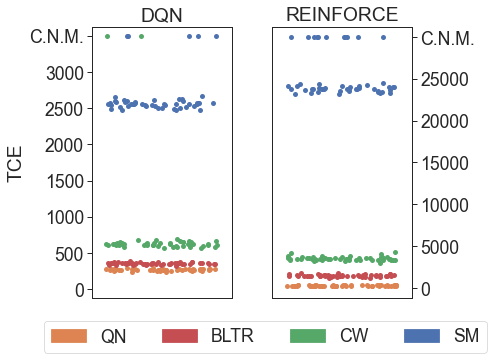

In [52]:
# Final results plotting
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
chosen_rules = [rule for rule in base_rules if rule not in ['CM','CM1F','CM2O']]
final_df = terminal_results_df.copy()
max_val_reinforce = final_df.query("learner=='REINFORCE'").adj_cumulative_error.max()
max_val_dqn = final_df.query("learner=='DQN'").adj_cumulative_error.max()

#fig, (ax1,ax2) = plt.subplots(figsize=(4,7),nrows=2,sharex=True, gridspec_kw={'height_ratios':[1,5]})

step = 500
tick_max_dqn= int((np.ceil(max_val_dqn/step)+2)*step)
ticks_dqn = [*range(0,tick_max_dqn,step)]
str_ticks_dqn = [str(i) for i in ticks_dqn]
str_ticks_dqn[-1]='C.N.M.'
colors = ['b','g','r','c']

fig = plt.figure(layout='constrained',figsize=(5,5))
subfigs = fig.subfigures(1,2,wspace=0.1)
ax1 = subfigs[0].subplots()
sp_rule_list = ['QN','BLTR','CW','SM']
palette = sns.color_palette(None,len(sp_rule_list))
sp_color = {"SM":palette[0],
            "QN":palette[1],
            "BLTR":palette[3],
            "CW":palette[2]}
jitter =0.4
for i,cr in enumerate(sp_rule_list):
    sns.stripplot(ax=ax1,data=final_df.query("learner=='DQN' & rule==@cr").fillna(ticks_dqn[-1]),y='adj_cumulative_error',color=sp_color[cr],jitter=jitter)
#ax1.set_ylim(0,5000)
#for i in range(4):
#    leg.legend_handles[0].setcolor(colors[i])
#ax1.set_yscale('log')
ax1.set_yticks(ticks_dqn)
ax1.set_yticklabels(str_ticks_dqn)
ax1.set_ylabel("TCE")
ax1.set_title("DQN")
ax1.set_xticks([])
ax1.set_ylim(ticks_dqn[0]-0.25*step,ticks_dqn[-1]+0.25*step)

step = 5000
tick_max_rn= int((np.ceil(max_val_reinforce/step)+2)*step)
ticks_rn = [*range(0,tick_max_rn,step)]
str_ticks_rn = [str(i) for i in ticks_rn]
str_ticks_rn[-1]='C.N.M.'
ax2 = subfigs[1].subplots()

for i,cr in enumerate(sp_rule_list):
    sns.stripplot(ax=ax2,data=final_df.query("learner=='REINFORCE' & rule==@cr").fillna(ticks_rn[-1]),y='adj_cumulative_error',color=sp_color[cr],jitter=jitter)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylim(ticks_rn[0]-0.25*step,ticks_rn[-1]+0.25*step)
#for i in range(4):
#    leg.legend_handles[0].setcolor(colors[i])
#ax1.set_yscale('log')
ax2.set_yticks(ticks_rn)
ax2.set_yticklabels(str_ticks_rn)
ax2.set_ylabel("")
ax2.set_title("REINFORCE")
ax2.set_xticks([])
#ax1.spines[['right','top']].set_visible(False)
#ax2.spines[['left','top']].set_visible(False)

# fig.legend(labels=['SM','QN','BLTR','CW'],loc='upper center', 
#              bbox_to_anchor=(0.5, -0.2),ncol=4)
handles, labels = ax1.get_legend_handles_labels()
for i,cr in enumerate(sp_rule_list):
    patch = mpatches.Patch(color=sp_color[cr],label=cr)
    handles.append(patch)

plt.legend(handles=handles,ncol=4,loc='upper center',bbox_to_anchor=(-0.05,-0.05))

plt.savefig(plot_dir+"rl_base_rules_sp.pdf",bbox_inches='tight',facecolor='w')

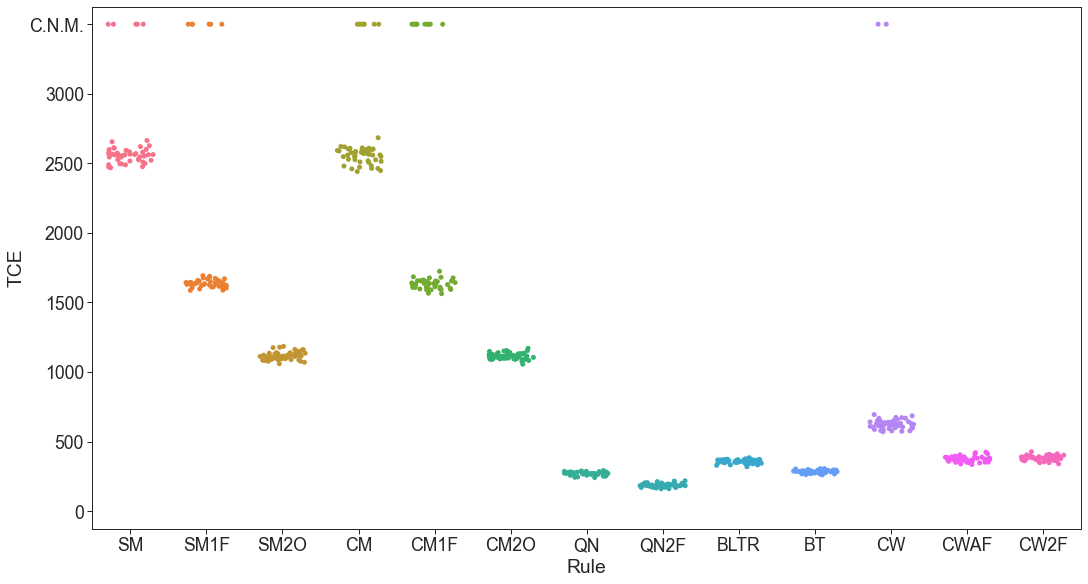

In [53]:
# Final results plotting
sns.set(font_scale=2)
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
chosen_rules = complete_rules
final_df = terminal_results_df.copy()
max_val_dqn = final_df.query("learner=='DQN'").adj_cumulative_error.max()

#fig, (ax1,ax2) = plt.subplots(figsize=(4,7),nrows=2,sharex=True, gridspec_kw={'height_ratios':[1,5]})

step = 500
tick_max_dqn= int((np.ceil(max_val_dqn/step)+2)*step)
ticks_dqn = [*range(0,tick_max_dqn,step)]
str_ticks_dqn = [str(i) for i in ticks_dqn]
str_ticks_dqn[-1]='C.N.M.'
#colors = ['b','g','r','c']

fig = plt.figure(layout='constrained',figsize=(15,8))
jitter =0.3
#for i,cr in enumerate(sp_rule_list):
sns.stripplot(data=final_df.query("learner=='DQN'").fillna(ticks_dqn[-1]),x='rule',hue='rule',order=chosen_rules,hue_order=chosen_rules,y='adj_cumulative_error',jitter=jitter,legend=False)
ax1=plt.gca()
ax1.set_yticks(ticks_dqn)
ax1.set_yticklabels(str_ticks_dqn)
ax1.set_ylabel("TCE")
ax1.set_xlabel("Rule")
ax1.set_ylim(ticks_dqn[0]-0.25*step,ticks_dqn[-1]+0.25*step)

plt.savefig(plot_dir+"rl_complete_rules_sp_dqn.pdf",bbox_inches='tight',facecolor='w')

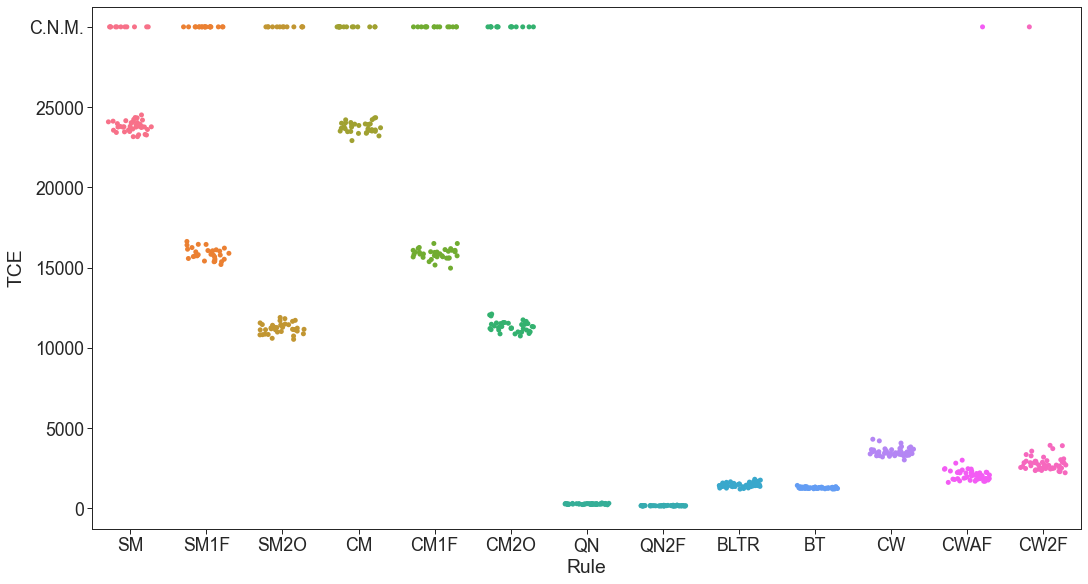

In [54]:
# Final results plotting
sns.set(font_scale=2)
sns.set_style('ticks')
sns.set_context('paper',font_scale=2)
chosen_rules = complete_rules
final_df = terminal_results_df.copy()
max_val_reinforce = final_df.query("learner=='REINFORCE'").adj_cumulative_error.max()
step = 5000
tick_max_rn= int((np.ceil(max_val_reinforce/step)+2)*step)
ticks_rn = [*range(0,tick_max_rn,step)]
str_ticks_rn = [str(i) for i in ticks_rn]
str_ticks_rn[-1]='C.N.M.'
fig = plt.figure(layout='constrained',figsize=(15,8))
sns.stripplot(data=final_df.query("learner=='REINFORCE'").fillna(ticks_rn[-1]),x='rule',hue='rule',order=chosen_rules,hue_order=chosen_rules,y='adj_cumulative_error',jitter=jitter,legend=False)
#ax1.set_ylim(0,5000)
#for i in range(4):
#    leg.legend_handles[0].setcolor(colors[i])
#ax1.set_yscale('log')
ax1=plt.gca()
ax1.set_yticks(ticks_rn)
ax1.set_yticklabels(str_ticks_rn)
ax1.set_ylabel("TCE")
ax1.set_xlabel("Rule")
#ax1.set_title("DQN")
#ax1.set_xticks([])
ax1.set_ylim(ticks_rn[0]-0.25*step,ticks_rn[-1]+0.25*step)
#plt.legend(title='Rule')
plt.savefig(plot_dir+"rl_complete_rules_sp_rn.pdf",bbox_inches='tight',facecolor='w')

In [124]:
# Base rules comparison
cur_rules = base_rules

final_nonan = final_df.copy().fillna(50000)

for alg in ['DQN','REINFORCE']:
    print(alg)
    mw_heatmap = np.empty((len(cur_rules),len(cur_rules)))
    mw_heatmap[:]=np.nan
    for idx,i in enumerate(cur_rules):
        for idy,j in enumerate(cur_rules):
            a = final_nonan.query("rule==@i & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            #print(a)
            b = final_nonan.query("rule==@j & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            #print(b)
            if np.isnan(mw_heatmap[idy,idx]):
                #u,p1 = mannwhitneyu(x=a,y=b,alternative="less",method="asymptotic")
                u,p1 = mannwhitneyu(x=a,y=b,method="asymptotic")
                #mw_heatmap[idx,idy]=np.around(p1,decimals=4)
                mw_heatmap[idx,idy]=p1
    print(mw_heatmap)

DQN
[[1.00000000e+00 6.24191526e-01 6.96634239e-18 6.96948781e-18
  1.70927488e-15]
 [           nan 1.00000000e+00 6.91463663e-18 6.91775994e-18
  1.51086268e-15]
 [           nan            nan 1.00000000e+00 6.95848471e-18
  6.98523511e-18]
 [           nan            nan            nan 1.00000000e+00
  6.98838861e-18]
 [           nan            nan            nan            nan
  1.00000000e+00]]
REINFORCE
[[1.00000000e+00 9.08635392e-01 6.69474949e-18 6.72053870e-18
  6.72357891e-18]
 [           nan 1.00000000e+00 6.19823285e-18 6.22220683e-18
  6.22503306e-18]
 [           nan            nan 1.00000000e+00 7.03267946e-18
  7.03585324e-18]
 [           nan            nan            nan 1.00000000e+00
  7.06288524e-18]
 [           nan            nan            nan            nan
  1.00000000e+00]]


In [125]:
# Generality comparisons
gen_comparisons = [['SM','SM1F','SM2O'],
                   ['CM','CM1F','CM2O'],
                   ['QN','QN2F'],
                   ['BLTR','BT'],
                   ['CW','CWAF','CW2F']]
for alg in ['DQN','REINFORCE']:
    print(alg)
    for rule_set in gen_comparisons:
        print(rule_set)
        if len(rule_set)==3:
            a = final_df.query("rule==@rule_set[0] & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            b = final_df.query("rule==@rule_set[1]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            c = final_df.query("rule==@rule_set[2]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            print(a.size,b.size,c.size)
            print("Comparing {} to {}".format(rule_set[1],rule_set[0]))
            u,p1 = mannwhitneyu(x=b,y=a,alternative="greater",method="asymptotic")
            print(p1)
            print("Comparing {} to {}".format(rule_set[2],rule_set[0]))
            u,p1 = mannwhitneyu(x=c,y=a,alternative="greater",method="asymptotic")
            print(p1)
        else:
            a = final_df.query("rule==@rule_set[0]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            b = final_df.query("rule==@rule_set[1]  & learner==@alg").adj_cumulative_error.to_numpy(dtype=int)
            print(a.size,b.size)
            print("Comparing {} to {}".format(rule_set[1],rule_set[0]))
            u,p1 = mannwhitneyu(x=b,y=a,alternative="greater",method="asymptotic")
            print(p1)
        print()
    print()

DQN
['SM', 'SM1F', 'SM2O']
50 50 50
Comparing SM1F to SM
0.9999999999987705
Comparing SM2O to SM
0.9999999999973671

['CM', 'CM1F', 'CM2O']
50 50 50
Comparing CM1F to CM
0.9999999999494211
Comparing CM2O to CM
0.9999999997342427

['QN', 'QN2F']
50 50
Comparing QN2F to QN
1.0

['BLTR', 'BT']
50 50
Comparing BT to BLTR
1.0

['CW', 'CWAF', 'CW2F']
50 50 50
Comparing CWAF to CW
0.9999999999999989
Comparing CW2F to CW
0.9999999999999989


REINFORCE
['SM', 'SM1F', 'SM2O']
50 50 50
Comparing SM1F to SM
0.9999999907737319
Comparing SM2O to SM
0.9999999581902929

['CM', 'CM1F', 'CM2O']
50 50 50
Comparing CM1F to CM
0.9999908252864078
Comparing CM2O to CM
0.9999881060701352

['QN', 'QN2F']
50 50
Comparing QN2F to QN
1.0

['BLTR', 'BT']
50 50
Comparing BT to BLTR
0.9999999999997159

['CW', 'CWAF', 'CW2F']
50 50 50
Comparing CWAF to CW
1.0
Comparing CW2F to CW
0.9999999999998833




episode                       3999
reward                           0
rule                            BT
params              naive_bd_ad_n6
memory                           6
experiment_id         11066979_123
trial                            0
featurization                BD_AD
learner                        DQN
ep_error                         0
cumulative_error               305
Name: 29367999, dtype: object
305


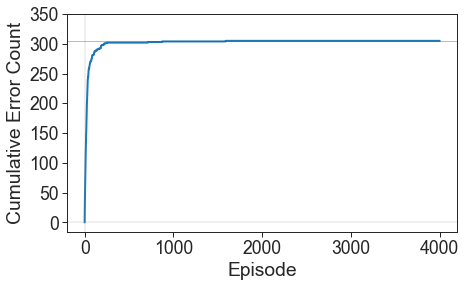

In [14]:
# Sample ML plot
episode_results_df.head()
sample=episode_results_df.query("experiment_id=='11066979_123' & trial=='0'").copy()
print(sample.iloc[-1])
sample.episode+=1
eps = sample.episode.to_numpy()
errs = sample.cumulative_error.to_numpy()
eps=np.insert(eps,1,0)
errs=np.insert(errs,1,0)

fig,ax = plt.subplots(figsize=(7,4))
sns.set_context('paper',font_scale=2)
sns.set_style('ticks')
sns.lineplot(ax=ax,x=eps,y=errs,linewidth=2)
ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Error Count')
max_val = sample.iloc[-1].cumulative_error
print(sample.iloc[-1].cumulative_error)
step = 50
tick_max = int((np.ceil(max_val/step)+1)*step)
ticks = [*range(0,tick_max,step)]
str_ticks = [str(i) for i in ticks]
ax.set_yticks(ticks)
ax.set_yticklabels(str_ticks)
#plt.plot(sample.iloc[-1].episode,max_val,'bo',markersize=10)
# Plot lines for the 0,0 axis lines
plt.axhline(0, color='gray',linewidth=0.25)
plt.axvline(0, color='gray', linewidth=0.25)
plt.axhline(305,color='r',linewidth=.5,alpha=0.75)
fig.savefig(plot_dir+'sample_ml_player.pdf',bbox_inches='tight',facecolor='w')


In [201]:
print(eps)

[   1    2    3 ... 3998 3999 4000]
